In [1]:
import pandas as pds

from sklearn import linear_model
from sklearn import metrics
from sqlalchemy import create_engine

# Import Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.svm import SVC

# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf

import numpy as np

import random

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import matplotlib.pyplot as plt

import pgeocode
import censusgeocode as cg


ModuleNotFoundError: No module named 'pgeocode'

In [4]:
# Create an engine for the chinook.sqlite database
# engine = create_engine("austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com", echo=False)
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("host=austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com dbname=austincrime user=postgres password=T1m3T0Party")
# dataframe = psql.read_sql('SELECT * FROM product_product', connection)
# product_category = psql.read_sql_query('select * from product_category', connection)

In [5]:
# create crime_df dataframe from postgres austincrimereports_filtered table

crime_df = psql.read_sql('SELECT * FROM austincrimereports_filtered', connection)
#crime_df.to_csv('austinCrimeReports_Filtered.csv')




In [6]:
#checking for null data
crime_df.isnull().sum()

ID                         0
GOHighestOffDesc           0
NIBRSUCROffDesc            0
FamilyViolence             0
OccurredDateTime          67
OccurredDate               0
OccurredTime               9
ReportDateTime             0
ReportDate                 0
ReportTime                 0
LocationType             430
Address                    0
ZipCode                  906
CouncilDistrict         1781
APDSector                595
APDDistrict              635
PRA                      651
CensusTract             1549
Clearance              14767
ClearanceDate          14808
UCRCategory                0
CategoryDescription        0
XCoordinate              514
YCoordinate              514
Latitude                5660
Longitude               5660
Location                5660
dtype: int64

In [7]:
# Generate our categorical variable list
crime_cat = crime_df.dtypes[crime_df.dtypes == "object"].index.tolist()

In [8]:
print(crime_cat)

['ID', 'GOHighestOffDesc', 'NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDate', 'ReportDate', 'LocationType', 'Address', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'Clearance', 'ClearanceDate', 'UCRCategory', 'CategoryDescription', 'Latitude', 'Longitude', 'Location']


In [9]:
#Looking at datatypes of data
crime_df.dtypes

ID                             object
GOHighestOffDesc               object
NIBRSUCROffDesc                object
FamilyViolence                 object
OccurredDateTime       datetime64[ns]
OccurredDate                   object
OccurredTime                  float64
ReportDateTime         datetime64[ns]
ReportDate                     object
ReportTime                      int64
LocationType                   object
Address                        object
ZipCode                        object
CouncilDistrict                object
APDSector                      object
APDDistrict                    object
PRA                            object
CensusTract                   float64
Clearance                      object
ClearanceDate                  object
UCRCategory                    object
CategoryDescription            object
XCoordinate                   float64
YCoordinate                   float64
Latitude                       object
Longitude                      object
Location    

In [10]:
# Dropping columns
cleaned_crime_df = crime_df.drop(['ID','GOHighestOffDesc','Location', 'ClearanceDate', 'Clearance','XCoordinate','YCoordinate','Location','Address','ReportDateTime','ReportDate','ReportTime'],axis = 1)
#cleaned_crime_df = cleaned_crime_df.drop(['Latitude','Longitude'],axis = 1)
print(cleaned_crime_df.count())

NIBRSUCROffDesc        272901
FamilyViolence         272901
OccurredDateTime       272834
OccurredDate           272901
OccurredTime           272892
LocationType           272471
ZipCode                271995
CouncilDistrict        271120
APDSector              272306
APDDistrict            272266
PRA                    272250
CensusTract            271352
UCRCategory            272901
CategoryDescription    272901
Latitude               267241
Longitude              267241
dtype: int64


In [11]:
# Changing Longitude and Latitude to float

cleaned_crime_df["Longitude"] = cleaned_crime_df.Longitude.astype(float)
cleaned_crime_df["Latitude"] = cleaned_crime_df.Latitude.astype(float)

In [13]:
# Setting pgeocode variable to user United States
nomi = pgeocode.Nominatim('US')

NameError: name 'pgeocode' is not defined

In [11]:
#iterating through rows assinging lats and longs to Rape crimes

for i,row in cleaned_crime_df.iterrows():
    if row['CategoryDescription'] == 'Rape':
        location = nomi.query_postal_code(row["ZipCode"])
        cleaned_crime_df["Latitude"][i] = location.latitude
        cleaned_crime_df["Longitude"][i] = location.longitude

In [12]:
# Drop the null rows
cleaned_crime_df = cleaned_crime_df.dropna()
print(cleaned_crime_df.count())

NIBRSUCROffDesc        269534
FamilyViolence         269534
OccurredDateTime       269534
OccurredDate           269534
OccurredTime           269534
LocationType           269534
ZipCode                269534
CouncilDistrict        269534
APDSector              269534
APDDistrict            269534
PRA                    269534
CensusTract            269534
UCRCategory            269534
CategoryDescription    269534
Latitude               269534
Longitude              269534
dtype: int64


# Trying to find a way to update census tracts in Crime data to match tracts in Census Data
result = cg.coordinates(x=cleaned_crime_df["Longitude"][1],y=cleaned_crime_df["Latitude"][1])
result["Census Tracts"][0]['BASENAME']   
result["Census Tracts"][0]['BASENAME']

cleaned_crime_df["Latitude"][1]
ctract_update_df = psql.read_sql('SELECT * FROM ctract_update', connection)


for lp in range(184):
    print("loop")
    print (lp)
    ctract_update_df.to_csv("ctract_udpate.csv")
    limit=500
    for i,row in ctract_update_df.iterrows():
        if row["newtract"] == '':
            result = cg.coordinates(x=(row["Longitude"]), y=(row["Latitude"]))
            newtract =   result["Census Tracts"][0]['BASENAME']
            ctract_update_df["newtract"][i] = newtract
            print("row")   
            print(i)
            if i == limit: break

ctract_update_df.to_csv("ctract_udpate.csv")


ctract_update_df.sort_values(
    by="newtract",
    ascending=False
)

#ctract_update_df.isnull().sum()
ctract_update_df.head(50)

#ctract_update_df = ctract_update_df.dropna()
#print(ctract_update_df.count())

In [13]:
cleaned_crime_df.CategoryDescription.value_counts()

Theft                 188733
Burglary               32649
Auto Theft             20441
Aggravated Assault     16024
Robbery                 6978
Rape                    4432
Murder                   277
Name: CategoryDescription, dtype: int64

# Grouping outcomes

In [14]:
cleaned_crime_df.columns

Index(['NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDateTime', 'OccurredDate',
       'OccurredTime', 'LocationType', 'ZipCode', 'CouncilDistrict',
       'APDSector', 'APDDistrict', 'PRA', 'CensusTract', 'UCRCategory',
       'CategoryDescription', 'Latitude', 'Longitude'],
      dtype='object')

In [15]:
cleaned_crime_df['CategoryDescription'].unique()

array(['Burglary', 'Theft', 'Aggravated Assault', 'Rape', 'Auto Theft',
       'Robbery', 'Murder'], dtype=object)

In [16]:
# violent crime is murder, aggravated assualt, robbery, and rape
grouped_crime_df = cleaned_crime_df.copy()

grouped_crime_df = grouped_crime_df.replace({'CategoryDescription': {'Rape': 'Violent Crime', 'Murder': 'Violent Crime', 
                                                  'Aggravated Assault':'Violent Crime', 'Robbery': 'Violent Crime'}})

#for i,row in grouped_crime_df.iterrows():
#    if row['CategoryDescription'] == ('Rape' or 'Murder'or 'Aggravated Assault', 'Robbery'):
#        grouped_crime_df["CategoryDescription"][i] = "Violent Crime"


# scale values

# Drop NaNs

In [17]:
# Check for null values
#cleaned_crime_df.isnull().sum()
grouped_crime_df.isnull().sum()

NIBRSUCROffDesc        0
FamilyViolence         0
OccurredDateTime       0
OccurredDate           0
OccurredTime           0
LocationType           0
ZipCode                0
CouncilDistrict        0
APDSector              0
APDDistrict            0
PRA                    0
CensusTract            0
UCRCategory            0
CategoryDescription    0
Latitude               0
Longitude              0
dtype: int64

In [18]:
# Drop the null rows
# cleaned_crime_df = cleaned_crime_df.dropna()
grouped_crime_df = grouped_crime_df.dropna()
print(cleaned_crime_df.count())

NIBRSUCROffDesc        269534
FamilyViolence         269534
OccurredDateTime       269534
OccurredDate           269534
OccurredTime           269534
LocationType           269534
ZipCode                269534
CouncilDistrict        269534
APDSector              269534
APDDistrict            269534
PRA                    269534
CensusTract            269534
UCRCategory            269534
CategoryDescription    269534
Latitude               269534
Longitude              269534
dtype: int64


In [19]:
# cleaned_crime_df.describe()
grouped_crime_df.describe()

,OccurredTime,CensusTract,Latitude,Longitude
count,269534.000000,269534.000000,269534.000000,269534.000000
mean,1319.445888,195.979442,30.298638,-97.737071
std,690.738574,673.410498,0.079108,0.047610
min,0.000000,1.000000,30.100612,-97.942700
25%,837.000000,15.000000,30.235206,-97.764586
50%,1430.000000,24.000000,30.288898,-97.734380
75%,1900.000000,341.000000,30.360807,-97.704476
max,2359.000000,9800.000000,30.513667,-97.578053


In [20]:
# putting Latitudes and Longitudes in Bins
#lat_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
#cleaned_crime_df['Latitude_bin'] = pds.qcut(cleaned_crime_df['Latitude'],
#                                                    q=20,labels  = lat_labels, precision = 4)
#long_labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
#cleaned_crime_df['Longitude_bin'] = pds.qcut(cleaned_crime_df['Longitude'],
#                                                    q=20,labels  = lat_labels, precision = 4)



# cleaned_crime_df.head()

In [21]:

cleaned_crime_df.head(50)
grouped_crime_df.head(50)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682
7,402,N,2019-08-26 18:00:00,2019-08-26,1800.0,RESIDENCE / HOME,78748,5,FR,1,101,17.74,13A,Violent Crime,30.155939,-97.833781
10,500,N,2019-09-17 02:00:00,2019-09-17,200.0,RESIDENCE / HOME,78753,4,ED,3,251,18.13,220,Burglary,30.352738,-97.691219
11,600,N,2019-05-03 12:00:00,2019-05-03,1200.0,RESIDENCE / HOME,78746,8,DA,4,464,19.11,23H,Theft,30.258364,-97.791562
12,601,N,2019-09-15 09:30:00,2019-09-15,930.0,RESIDENCE / HOME,78705,9,BA,1,347,5.00,23F,Theft,30.295829,-97.729225
13,601,N,2019-08-26 21:20:00,2019-08-26,2120.0,RESIDENCE / HOME,78741,3,HE,4,458,23.14,23F,Theft,30.229358,-97.726219


In [22]:
# checking number of unique values per column
cleaned_crime_df.nunique()

NIBRSUCROffDesc            57
FamilyViolence              2
OccurredDateTime       196426
OccurredDate             2628
OccurredTime             1440
LocationType               45
ZipCode                    50
CouncilDistrict            10
APDSector                  12
APDDistrict                15
PRA                       511
CensusTract               251
UCRCategory                16
CategoryDescription         7
Latitude                64337
Longitude               64279
dtype: int64

In [23]:
# separating out month and day 
grouped_crime_df['OccurredDate_Month'] = pds.DatetimeIndex(grouped_crime_df['OccurredDate']).month
grouped_crime_df['OccurredDate_Day'] = pds.DatetimeIndex(grouped_crime_df['OccurredDate']).day
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,4,9
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,9,1
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,3,13
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,9,10
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,9,9


In [24]:
# Adding day of the week column

grouped_crime_df['OccurredDate'] = pds.to_datetime(grouped_crime_df['OccurredDate'])
grouped_crime_df['OccurredDate_DayOfWeek'] = grouped_crime_df['OccurredDate'].dt.dayofweek
grouped_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206.0,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145.0,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443.0,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15.0,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350.0,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,9,9,0


In [25]:
# making OccurredTime an integer datatype for example 10:45 pm would be 2245

grouped_crime_df['OccurredTime'] = grouped_crime_df['OccurredTime'].astype(int)
grouped_crime_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,4,9,1
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,9,1,6
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,3,13,2
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,9,10,1
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,9,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,600,N,2019-08-10 00:00:00,2019-08-10,0,OTHER / UNKNOWN,78701,9,GE,2,382,11.00,23H,Theft,30.266581,-97.736928,8,10,5
119,614,N,2016-02-02 00:00:00,2016-02-02,0,RESIDENCE / HOME,78724,1,CH,7,302,22.22,23G,Theft,30.298881,-97.644715,2,2,1
120,603,N,2019-09-23 19:00:00,2019-09-23,1900,RESIDENCE / HOME,78753,4,ED,3,251,18.13,23F,Theft,30.351668,-97.691901,9,23,0
122,601,N,2019-09-14 17:00:00,2019-09-14,1700,RESIDENCE / HOME,78741,3,HE,2,457,23.16,23F,Theft,30.238052,-97.732174,9,14,5


In [26]:
# creating OccurredHour to help group crimes by the hour
grouped_crime_df['OccurredHour'] = (grouped_crime_df['OccurredTime'] / 100).apply(np.floor).astype(int) *100
grouped_crime_df.head()


,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,N,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,4,9,1,1200
2,600,N,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,9,1,6,2100
3,500,N,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,3,13,2,1400
4,609,N,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,9,10,1,0
6,600,N,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,9,9,0,1300


In [27]:
# Generate our categorical variable list
crime_cat = grouped_crime_df.dtypes[grouped_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'FamilyViolence', 'LocationType', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']


In [28]:
crime_type_counts = grouped_crime_df.CategoryDescription.value_counts()
crime_type_counts

Theft            188733
Burglary          32649
Violent Crime     27711
Auto Theft        20441
Name: CategoryDescription, dtype: int64

In [29]:
# 'LocationType', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']
#  "FamilyViolence","OccurredTime","LocationType","ZipCode","CouncilDistrict","APDSector","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"

#LocationType_counts = cleaned_crime_df.LocationType.value_counts()
#LocationType_counts

# Determine which values to replace if counts are less than ...?
#replace_locationType = list(LocationType_counts[LocationType_counts < 150].index)

# Replace in dataframe
#for location in replace_locationType:
#    cleaned_crime_df.LocationType = cleaned_crime_df.LocationType.replace(location,"Other")
    
# Check to make sure binning was successful
#cleaned_crime_df.LocationType.value_counts()



In [30]:
#changing FamilyViolence to 0s and 1s instead of y and n

grouped_crime_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
grouped_crime_df['FamilyViolence'] = grouped_crime_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
grouped_crime_df['CouncilDistrict'] = grouped_crime_df['CouncilDistrict'].astype(int)


# changing PRA to integer
grouped_crime_df['PRA'] = grouped_crime_df['PRA'].astype(int)
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,PRA,CensusTract,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,493,24.11,220,Burglary,30.201607,-97.751976,4,9,1,1200
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,420,10.00,23H,Theft,30.252086,-97.721731,9,1,6,2100
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,527,24.22,220,Burglary,30.188782,-97.787951,3,13,2,1400
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,346,5.00,23H,Theft,30.300059,-97.734236,9,10,1,0
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,375,7.00,23H,Theft,30.282249,-97.746682,9,9,0,1300


In [31]:
# Generate our categorical variable list
crime_cat = grouped_crime_df.dtypes[grouped_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)


['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [32]:
location_freq = cleaned_crime_df['LocationType'].value_counts()
# print(location_freq)
num_locations = len(location_freq)
locations = location_freq.keys()
location_dist = {}
for loc in range(num_locations):
    location_key = locations[loc]
    location_dist[location_key] = round(location_freq.values[loc] / grouped_crime_df.shape[0], 5)
    
location_dist

{'RESIDENCE / HOME': 0.35113,
 'PARKING LOTS / GARAGE': 0.18504,
 'STREETS / HWY / ROAD / ALLEY': 0.0848,
 'OTHER / UNKNOWN': 0.08294,
 'DEPARTMENT / DISCOUNT STORE': 0.04857,
 'COMMERCIAL / OFFICE BUILDING': 0.04106,
 'GROCERY / SUPERMARKET': 0.03395,
 'HOTEL / MOTEL / ETC.': 0.02208,
 'RESTAURANTS': 0.02179,
 'CONVENIENCE STORE': 0.01908,
 'BAR / NIGHT CLUB': 0.01399,
 'SPECIALTY  STORE (TV  FUR ETC.)': 0.0128,
 'GAS / SERVICE STATIONS': 0.01261,
 'PARK / PLAYGROUND': 0.01001,
 'CONSTRUCTION SITE': 0.00867,
 'RENTAL STORAGE FACILITY': 0.0072,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 0.00705,
 'LIQUOR STORE': 0.00541,
 'GOVERNMENT / PUBLIC BUILDING': 0.00439,
 'SHOPPING MALL': 0.00426,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 0.00401,
 'AUTO DEALERSHIP NEW / USED': 0.00388,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 0.00229,
 'FIELD / WOODS': 0.00212,
 'BANKS / SAVINGS & LOAN': 0.002,
 'ABANDONED/CONDEMNED STRUCTURE': 0.00153,
 'COMMUNITY CENTER': 0.00097,
 'SCHOOLS / COLLEGES':

In [33]:
ranking_dict = {}

for i in range(len(grouped_crime_df['LocationType'].value_counts())):
    location_key = locations[i]
    
    ranking_dict[location_key] = i + 1
    
ranking_dict

{'RESIDENCE / HOME': 1,
 'PARKING LOTS / GARAGE': 2,
 'STREETS / HWY / ROAD / ALLEY': 3,
 'OTHER / UNKNOWN': 4,
 'DEPARTMENT / DISCOUNT STORE': 5,
 'COMMERCIAL / OFFICE BUILDING': 6,
 'GROCERY / SUPERMARKET': 7,
 'HOTEL / MOTEL / ETC.': 8,
 'RESTAURANTS': 9,
 'CONVENIENCE STORE': 10,
 'BAR / NIGHT CLUB': 11,
 'SPECIALTY  STORE (TV  FUR ETC.)': 12,
 'GAS / SERVICE STATIONS': 13,
 'PARK / PLAYGROUND': 14,
 'CONSTRUCTION SITE': 15,
 'RENTAL STORAGE FACILITY': 16,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 17,
 'LIQUOR STORE': 18,
 'GOVERNMENT / PUBLIC BUILDING': 19,
 'SHOPPING MALL': 20,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 21,
 'AUTO DEALERSHIP NEW / USED': 22,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 23,
 'FIELD / WOODS': 24,
 'BANKS / SAVINGS & LOAN': 25,
 'ABANDONED/CONDEMNED STRUCTURE': 26,
 'COMMUNITY CENTER': 27,
 'SCHOOLS / COLLEGES': 28,
 'SCHOOL - ELEMENTARY / SECONDARY': 29,
 'SCHOOL - COLLEGE / UNIVERSITY': 30,
 'SHELTER-MISSION / HOMELESS': 31,
 'LAKE / WATERWAY': 3

In [34]:
crime_cat = ['LocationType']

In [35]:
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
apple = grouped_crime_df.copy()[crime_cat]
parent['ranking']=pen.replace(ranking_dict)
parent['location_dist'] = pen.replace(location_dist)

grouped_crime_df["location_ranking"] = parent["ranking"]
grouped_crime_df["location_dist"] = parent["location_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UCRCategory,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,220,Burglary,30.201607,-97.751976,4,9,1,1200,1,0.35113
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,23H,Theft,30.252086,-97.721731,9,1,6,2100,1,0.35113
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,220,Burglary,30.188782,-97.787951,3,13,2,1400,1,0.35113
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,23H,Theft,30.300059,-97.734236,9,10,1,0,1,0.35113
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,23H,Theft,30.282249,-97.746682,9,9,0,1300,1,0.35113


In [36]:
# Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
# encode_df = pds.DataFrame(enc.fit_transform(cleaned_crime_df[crime_cat]))
# Add the encoded variable names to the DataFrame
# encode_df.columns = enc.get_feature_names(crime_cat)
# encode_df.head()

In [37]:
# Merge one-hot encoded features and drop the originals
# ml_cleaned_crime_df = cleaned_crime_df.merge(encode_df,left_index=True,right_index=True)
# ml_cleaned_crime_df = cleaned_crime_df.drop(columns=crime_cat, axis=1)
# ml_cleaned_crime_df.head()

In [38]:
# Find frequency pct of each CensusTract

censustract_freq = grouped_crime_df['CensusTract'].value_counts()
# print(location_freq)
num_censustracts = len(censustract_freq)
censustracts = censustract_freq.keys()
censustract_dist = {}
for tract in range(num_censustracts):
    censustract_key = censustracts[tract]
    censustract_dist[censustract_key] = round(censustract_freq.values[tract] / grouped_crime_df.shape[0], 5)
    
censustract_dist

{11.0: 0.04909,
 21.0: 0.03883,
 3.0: 0.03192,
 15.0: 0.02695,
 9.0: 0.02369,
 23.0: 0.02321,
 204.0: 0.02142,
 6.0: 0.02045,
 20.0: 0.01936,
 454.0: 0.01751,
 403.0: 0.01735,
 13.0: 0.01694,
 2.0: 0.01496,
 8.0: 0.01372,
 24.37: 0.0132,
 324.0: 0.01129,
 24.0: 0.01077,
 23.22: 0.0106,
 407.0: 0.01037,
 400.0: 0.01034,
 12.0: 0.01002,
 14.0: 0.00984,
 410.0: 0.00968,
 439.0: 0.00954,
 421.0: 0.00911,
 19.1: 0.00881,
 4.0: 0.0087,
 401.0: 0.00868,
 405.0: 0.00866,
 23.14: 0.00854,
 416.0: 0.00834,
 16.0: 0.00817,
 24.11: 0.00806,
 23.16: 0.00806,
 203.34: 0.00779,
 19.11: 0.00756,
 409.0: 0.00748,
 24.48: 0.00736,
 308.0: 0.0073,
 13.12: 0.00718,
 24.43: 0.00707,
 434.0: 0.007,
 406.0: 0.00698,
 24.22: 0.00696,
 1.0: 0.00637,
 21.11: 0.00635,
 325.0: 0.00631,
 24.19: 0.0063,
 321.0: 0.00627,
 404.0: 0.00618,
 440.0: 0.00599,
 203.11: 0.00597,
 25.0: 0.00597,
 24.51: 0.00588,
 21.12: 0.00569,
 433.0: 0.00542,
 432.0: 0.00539,
 408.0: 0.00536,
 23.24: 0.0053,
 23.13: 0.0053,
 24.41: 0.005

In [39]:
#Add the censustract frequency pct and ranking as columns to dataframe

crime_cat = ['CensusTract']
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
parent['censustract_dist']=pen.replace(censustract_dist)

grouped_crime_df["censustract_dist"] = parent["censustract_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,CategoryDescription,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,Burglary,30.201607,-97.751976,4,9,1,1200,1,0.35113,0.00806
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,Theft,30.252086,-97.721731,9,1,6,2100,1,0.35113,0.00443
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,Burglary,30.188782,-97.787951,3,13,2,1400,1,0.35113,0.00696
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,Theft,30.300059,-97.734236,9,10,1,0,1,0.35113,0.00457
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,Theft,30.282249,-97.746682,9,9,0,1300,1,0.35113,0.00449


In [40]:
# Find frequency pct of each Zipcode

zipcode_freq = grouped_crime_df['ZipCode'].value_counts()
num_zipcodes = len(zipcode_freq)
zipcodes = zipcode_freq.keys()
zipcode_dist = {}
for zip in range(num_zipcodes):
    zipcode_key = zipcodes[zip]
    zipcode_dist[zipcode_key] = round(zipcode_freq.values[zip] / grouped_crime_df.shape[0], 5)
    
zipcode_dist

{'78753': 0.08214,
 '78741': 0.07896,
 '78758': 0.07461,
 '78704': 0.07423,
 '78701': 0.05511,
 '78723': 0.05393,
 '78745': 0.05393,
 '78744': 0.04614,
 '78759': 0.04339,
 '78702': 0.0429,
 '78748': 0.03338,
 '78752': 0.03309,
 '78705': 0.03139,
 '78757': 0.02805,
 '78751': 0.02491,
 '78746': 0.02159,
 '78749': 0.01977,
 '78731': 0.01728,
 '78703': 0.017,
 '78727': 0.01677,
 '78729': 0.0153,
 '78754': 0.01369,
 '78724': 0.01301,
 '78750': 0.01297,
 '78721': 0.01287,
 '78756': 0.00953,
 '78717': 0.00902,
 '78735': 0.0086,
 '78613': 0.00802,
 '78722': 0.00763,
 '78617': 0.00649,
 '78660': 0.00644,
 '78747': 0.0063,
 '78726': 0.00602,
 '78719': 0.00412,
 '78739': 0.00257,
 '78736': 0.00253,
 '78730': 0.00246,
 '78725': 0.0012,
 '78742': 0.00106,
 '78712': 0.00043,
 '78653': 0.0004,
 '78728': 0.00031,
 '78652': 0.00023,
 '78737': 0.00013,
 '78732': 0.0001,
 '78733': 3e-05,
 '78610': 1e-05,
 '78664': 0.0,
 '78734': 0.0}

In [41]:
#Add the zipcode frequency pct as column to dataframe

crime_cat = ['ZipCode']
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
parent['zipcode_dist']=pen.replace(zipcode_dist)

grouped_crime_df["zipcode_dist"] = parent["zipcode_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,Latitude,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,30.201607,-97.751976,4,9,1,1200,1,0.35113,0.00806,0.04614
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,30.252086,-97.721731,9,1,6,2100,1,0.35113,0.00443,0.04290
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,30.188782,-97.787951,3,13,2,1400,1,0.35113,0.00696,0.05393
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,30.300059,-97.734236,9,10,1,0,1,0.35113,0.00457,0.03139
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,30.282249,-97.746682,9,9,0,1300,1,0.35113,0.00449,0.05511


In [42]:
# Generate our categorical variable list
crime_cat = grouped_crime_df.dtypes[grouped_crime_df.dtypes == "object"].index.tolist()
print(crime_cat)


['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [43]:
# Find frequency pct of each APDSector
crime_cat = ['APDSector']
apdsector_freq = grouped_crime_df['APDSector'].value_counts()
num_apdsectors = len(apdsector_freq)
apdsectors = apdsector_freq.keys()
apdsector_dist = {}
for sector in range(num_apdsectors):
    apdsector_key = apdsectors[sector]
    apdsector_dist[apdsector_key] = round(apdsector_freq.values[sector] / grouped_crime_df.shape[0], 5)
    
apdsector_dist

{'DA': 0.14396,
 'ED': 0.13585,
 'AD': 0.13227,
 'BA': 0.12385,
 'FR': 0.10964,
 'ID': 0.10793,
 'HE': 0.09942,
 'CH': 0.089,
 'GE': 0.0533,
 'AP': 0.00407,
 'UT': 0.00053,
 '88': 0.00017}

In [44]:
# Find frequency pct of each APDDistrict

crime_cat = ['APDDistrict']
apddistrict_freq = grouped_crime_df['APDDistrict'].value_counts()
num_apddistricts = len(apddistrict_freq)
apddistricts = apddistrict_freq.keys()
apddistrict_dist = {}
for district in range(num_apddistricts):
    apddistrict_key = apddistricts[district]
    apddistrict_dist[apddistrict_key] = round(apddistrict_freq.values[district] / grouped_crime_df.shape[0], 5)
    
apddistrict_dist

{'2': 0.19848,
 '1': 0.1925,
 '3': 0.1214,
 '4': 0.11998,
 '6': 0.10191,
 '7': 0.10044,
 '5': 0.09621,
 '8': 0.06419,
 'S': 0.00301,
 'D': 0.00103,
 'B': 0.00045,
 '88': 0.00017,
 'A': 8e-05,
 'C': 8e-05,
 'P': 7e-05}

In [45]:
# Find frequency pct of each UCRCategory

crime_cat = ['UCRCategory']
ucr_freq = grouped_crime_df['UCRCategory'].value_counts()
num_ucrs = len(ucr_freq)
ucrs = ucr_freq.keys()
ucr_dist = {}
for category in range(num_ucrs):
    ucr_key = ucrs[category]
    ucr_dist[ucr_key] = round(ucr_freq.values[category] / grouped_crime_df.shape[0], 5)
    
ucr_dist

{'23H': 0.29346,
 '23F': 0.27526,
 '220': 0.12113,
 '23C': 0.07802,
 '240': 0.07584,
 '13A': 0.05945,
 '23G': 0.03168,
 '120': 0.02589,
 '23A': 0.01294,
 '11A': 0.01007,
 '23D': 0.00705,
 '11C': 0.00503,
 '23E': 0.00163,
 '11B': 0.00134,
 '09A': 0.00103,
 '23B': 0.00018}

In [46]:
#Add the APDSector frequency pct as column to dataframe

crime_cat = ['APDSector']
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
parent['apdsector_dist']=pen.replace(apdsector_dist)

grouped_crime_df["apdsector_dist"] = parent["apdsector_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,Longitude,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist,apdsector_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,-97.751976,4,9,1,1200,1,0.35113,0.00806,0.04614,0.10964
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,-97.721731,9,1,6,2100,1,0.35113,0.00443,0.04290,0.08900
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,-97.787951,3,13,2,1400,1,0.35113,0.00696,0.05393,0.10964
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,-97.734236,9,10,1,0,1,0.35113,0.00457,0.03139,0.12385
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,-97.746682,9,9,0,1300,1,0.35113,0.00449,0.05511,0.12385


In [47]:
#Add the APDDistrict frequency pct as column to dataframe

crime_cat = ['APDDistrict']
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
parent['apddistrict_dist']=pen.replace(apddistrict_dist)

grouped_crime_df["apddistrict_dist"] = parent["apddistrict_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist,apdsector_dist,apddistrict_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,4,9,1,1200,1,0.35113,0.00806,0.04614,0.10964,0.09621
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,9,1,6,2100,1,0.35113,0.00443,0.04290,0.08900,0.19250
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,3,13,2,1400,1,0.35113,0.00696,0.05393,0.10964,0.12140
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,9,10,1,0,1,0.35113,0.00457,0.03139,0.12385,0.19250
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,9,9,0,1300,1,0.35113,0.00449,0.05511,0.12385,0.19848


In [48]:
#Add the UCRCategory frequency pct as column to dataframe

crime_cat = ['UCRCategory']
parent = grouped_crime_df.copy()[crime_cat]
pen= grouped_crime_df.copy()[crime_cat]
parent['ucrcategory_dist']=pen.replace(ucr_dist)

grouped_crime_df["ucrcategory_dist"] = parent["ucrcategory_dist"]
grouped_crime_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist,apdsector_dist,apddistrict_dist,ucrcategory_dist
1,500,False,2019-04-09 12:06:00,2019-04-09,1206,RESIDENCE / HOME,78744,2,FR,5,...,9,1,1200,1,0.35113,0.00806,0.04614,0.10964,0.09621,0.12113
2,600,False,2019-09-01 21:45:00,2019-09-01,2145,RESIDENCE / HOME,78702,3,CH,1,...,1,6,2100,1,0.35113,0.00443,0.04290,0.08900,0.19250,0.29346
3,500,False,2019-03-13 14:43:00,2019-03-13,1443,RESIDENCE / HOME,78745,2,FR,3,...,13,2,1400,1,0.35113,0.00696,0.05393,0.10964,0.12140,0.12113
4,609,False,2019-09-10 00:15:00,2019-09-10,15,RESIDENCE / HOME,78705,9,BA,1,...,10,1,0,1,0.35113,0.00457,0.03139,0.12385,0.19250,0.29346
6,600,False,2019-09-09 13:50:00,2019-09-09,1350,RESIDENCE / HOME,78701,9,BA,2,...,9,0,1300,1,0.35113,0.00449,0.05511,0.12385,0.19848,0.29346


In [49]:
for col in grouped_crime_df.columns:
    print(col)

NIBRSUCROffDesc
FamilyViolence
OccurredDateTime
OccurredDate
OccurredTime
LocationType
ZipCode
CouncilDistrict
APDSector
APDDistrict
PRA
CensusTract
UCRCategory
CategoryDescription
Latitude
Longitude
OccurredDate_Month
OccurredDate_Day
OccurredDate_DayOfWeek
OccurredHour
location_ranking
location_dist
censustract_dist
zipcode_dist
apdsector_dist
apddistrict_dist
ucrcategory_dist


In [63]:
# Remove CategoryDescription target from features data
y = grouped_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin",
# "OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = grouped_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","ZipCode","APDSector","APDDistrict",
                              "UCRCategory","ucrcategory_dist","CategoryDescription"],axis = 1)
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [64]:
# create a function to print model output/results
def print_model_output(test, pred):

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Auto Theft', 'Violent Crime', 'Theft', 'Burglary']))

In [65]:
#Create a function to create a confusion matrix visualization
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [78]:
#create a function to display feature importance

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pds.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [67]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
# print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")



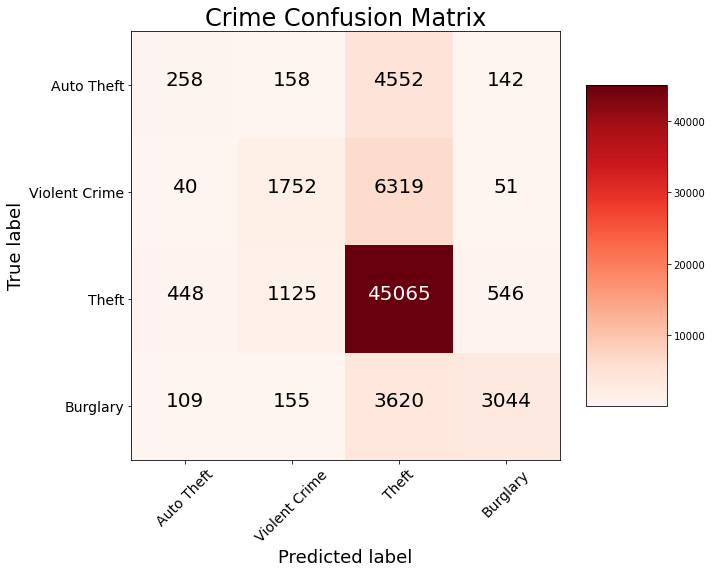

In [71]:
#Create a Confusion Matrix visual
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, classes = ['Auto Theft', 'Violent Crime', 'Theft', 'Burglary'],
                      title = 'Crime Confusion Matrix')

In [72]:
# Print out confusion matrix and all results
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

# call model print function
print_model_output(y_test, y_pred)

Confusion Matrix

[[  258   158  4552   142]
 [   40  1752  6319    51]
 [  448  1125 45065   546]
 [  109   155  3620  3044]]

Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.60
Macro Recall: 0.41
Macro F1-score: 0.45

Weighted Precision: 0.70
Weighted Recall: 0.74
Weighted F1-score: 0.69

Classification Report

               precision    recall  f1-score   support

   Auto Theft       0.30      0.05      0.09      5110
Violent Crime       0.55      0.21      0.31      8162
        Theft       0.76      0.96      0.84     47184
     Burglary       0.80      0.44      0.57      6928

     accuracy                           0.74     67384
    macro avg       0.60      0.41      0.45     67384
 weighted avg       0.70      0.74      0.69     67384



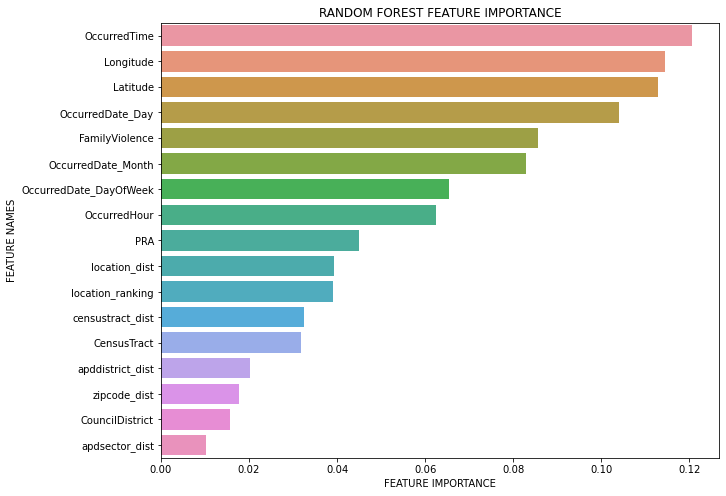

In [79]:
#call the Feature importance visualization function
plot_feature_importance(rf_model.feature_importances_,X.columns,'RANDOM FOREST')

In [82]:
print(rf_model.feature_importances_)
print(f" There are {len(rf_model.feature_importances_)} features in total")

[0.08572916 0.12069926 0.0156807  0.04501708 0.03175178 0.11288346
 0.11456795 0.08291139 0.10399987 0.0653737  0.06241006 0.03896599
 0.03925567 0.0323928  0.01778178 0.01033218 0.02024717]
 There are 17 features in total


# Hyperparameter Tuning

In [ ]:
# The objective function defines what we want to optimize


def objective(trial, X_data = X, Y_data = y):
    
    x_train, x_test, y_train, y_test = train_test_split(
        X_data, Y_data, random_state= 2021, test_size = 0.20)
    

    param = {
    'n_estimators': trial.suggest_categorical('n_estimators',[100,600,1000,1100]),
    # 'tree_method':'gpu_hist', # use GPU for train
    # 'predictor': 'gpu_predictor', # use GPU for predict
    'learning_rate': trial.suggest_discrete_uniform('learning_rate',0.01,0.50,0.05),
    'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel',0.01,0.91, 0.1),
    'colsample_bynode': trial.suggest_discrete_uniform('colsample_bytree',0.01,0.91, 0.1),
    'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree',0.01,0.91, 0.1),
    'max_depth': trial.suggest_int('max_depth', 1,10),
    'subsample': trial.suggest_discrete_uniform('subsample', 0.20,1, 0.05),
    
    'min_child_weight': trial.suggest_int('min_child_weight', 1,401,step=2),
    'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
    'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
    'random_state': trial.suggest_categorical('random_state',[2000,3000,4000]),
    'gamma': trial.suggest_discrete_uniform('gamma',0.01,2.01, 0.1)
    }
    
    model = xgb.XGBClassifier(**param)  
    
    model.fit(x_train,y_train,eval_set=[(x_train,y_train)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(x_test)
    
   
    precision, recall, f_score, _ = precision_recall_fscore_support(y_text, preds)
    
    return precision

In [ ]:
x_pen = grouped_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","ZipCode","APDSector","APDDistrict",
                              "UCRCategory","ucrcategory_dist","CategoryDescription"],axis = 1)
y_pen = grouped_crime_df.CategoryDescription

In [ ]:
# The objective function defines what we want to optimize
import optuna

def objective(trial, X_data = x_pen, Y_data = y_pen):
    
    x_train, x_test, y_train, y_test = train_test_split(
        X_data, Y_data, random_state= 2021, test_size = 0.20)
    

    param = {
    'n_estimators': trial.suggest_categorical('n_estimators',[10,20]),
    'random_state': trial.suggest_categorical('random_state',[2000,3000,4000]),
    'criterion': trial.suggest_categorical('criterion',["gini","entropy"]),
    'max_depth': trial.suggest_int('max_depth', 1,10),
    'min_samples_split': trial.suggest_int('min_samples_split',2,5),
    'verbose': trial.suggest_int('verbose', 0, 3)    
    # 'tree_method':'gpu_hist', # use GPU for train
    # 'predictor': 'gpu_predictor', # use GPU for predict
#     'learning_rate': trial.suggest_discrete_uniform('learning_rate',0.01,0.50,0.05),
#     'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel',0.01,0.91, 0.1),
#     'colsample_bynode': trial.suggest_discrete_uniform('colsample_bytree',0.01,0.91, 0.1),
#     'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree',0.01,0.91, 0.1),
#     'max_depth': trial.suggest_int('max_depth', 1,10),
#     'subsample': trial.suggest_discrete_uniform('subsample', 0.20,1, 0.05),
    
#     'min_child_weight': trial.suggest_int('min_child_weight', 1,401,step=2),
#     'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
#     'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
#     'random_state': trial.suggest_categorical('random_state',[2000,3000,4000]),
#     'gamma': trial.suggest_discrete_uniform('gamma',0.01,2.01, 0.1)
     }
    
    model = RandomForestClassifier(**param)  
    
    model.fit(x_train,y_train)
    
    preds = model.predict(x_test)
    
   
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, preds)
    
    return precision

In [ ]:
# create a study and specify we want to minimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 2)

## Ending of hyperparam tuning

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Aggravated Assault', 'Auto Theft', 'Burglary','Murder','Rape','Robbery', 'Theft' ],
                      title = 'Crime Confusion Matrix')

In [ ]:
y.value_counts()

#random forest, logistics regression, or gradient boosted trres {sklearn and xgboost}

# sampling
    # over sampling
    # under sampling
    # data augmentation
    # from imbalanced-learn package

In [ ]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin",
#                       "Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = cleaned_crime_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","ZipCode","APDSector",
                           "APDDistrict","UCRCategory","ucrcategory_dist","CategoryDescription"],axis = 1).values
# Split training/test datasets
X

In [ ]:
# Multinomial Logistic Regression, CensusTract
# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df.CensusTract
# X = cleaned_crime_df.CensusTract.values.reshape(-1, 1)

# y = cleaned_crime_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin","OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
# X = cleaned_crime_df.drop(["NIBRSUCROffDesc","OccurredDateTime","OccurredDate",
#                              "APDSector","APDDistrict","UCRCategory","CategoryDescription",
#                              "Latitude","Longitude","OccurredDate_Day"],axis = 1).values
# Split training/test datasets

# X



In [ ]:
X.reshape(1, -1)

In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',)
# fit the model on the whole dataset
model.fit(X_train_scaled, y_train)

# define a single row of input data
census_tract_list= cleaned_crime_df.CensusTract.unique().tolist()
random_census_tract= random.choice(census_tract_list)
census_tract= [random_census_tract]


For each iteration, reshape the array to (1,-1) 
then pass the reshaped array into the model

In [ ]:
# predict the class label
yhat = model.predict(X_test_scaled)
yhat
# summarize the predicted class
# print('Census Tract: %s, Predicted Crime Type: %s' % (census_tract, yhat[0]))

In [ ]:
print(classification_report(y_test, yhat))

In [ ]:
sns.pairplot(cleaned_crime_df,x_vars=['Latitude',],y_vars=['Longitude'],hue='CategoryDescription')

In [ ]:
cenustracts = cleaned_crime_df.CensusTract.value_counts()
cenustracts